In [1]:
# Notebook to perform the gamma/hadron separation using scikit-learn routines

from astropy.io import fits
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math as m
from ctapipe.instrument import OpticsDescription
import astropy.units as u
import ctapipe.coordinates as c
import matplotlib as mpl
import sys
sys.path.insert(0, '../')

import reco.Disp as Disp

In [2]:
# Open files
hdu_gamma = fits.open("../../cta-lstchain-extra/reco/sample_data/dl2/Gamma_events.fits") #File with events                                                                                                                                                                              
hdu_proton = fits.open("../../cta-lstchain-extra/reco/sample_data/dl2/Proton_events.fits") #File with events

data_gamma = hdu_gamma[1].data
data_proton = hdu_proton[1].data

In [3]:
tel = OpticsDescription.from_name('LST') #Telescope description                                                                                                                                                                                                           
focal_length = tel.equivalent_focal_length.value #Telescope focal length   

disp = np.array([]) #Disp quantity                                                                                                                                                                                                                                        

width = np.append(data_gamma.field('width'),
                  data_proton.field('width'))
length = np.append(data_gamma.field('length'),
                   data_proton.field('length'))
size = np.append(data_gamma.field('size'),
                 data_proton.field('size'))
phi = np.append(data_gamma.field('phi'),
                data_proton.field('phi'))
energy = np.append(np.log10(data_gamma.field('mcEnergy')*1e3),
                   np.log10(data_proton.field('mcEnergy')*1e3))
#Log of energy in GeV                                                                                                                                                                                                                                                     
cen_x = np.append(data_gamma.field('cen_x'),
                  data_proton.field('cen_x'))
cen_y = np.append(data_gamma.field('cen_y'),
                  data_proton.field('cen_y'))
psi = np.append(data_gamma.field('psi'),
                data_proton.field('psi'))
r = np.append(data_gamma.field('r'),
              data_proton.field('r'))

mcAlt = np.append(data_gamma.field('mcAlt'),
                  data_proton.field('mcAlt'))
mcAz = np.append(data_gamma.field('mcAz'),
                 data_proton.field('mcAz'))
mcAlttel = np.append(data_gamma.field('mcAlttel'),
                     data_proton.field('mcAlttel'))
mcAztel = np.append(data_gamma.field('mcAztel'),
                    data_proton.field('mcAztel'))

sourcepos = Disp.calc_CamSourcePos(mcAlt,mcAz,mcAlttel,mcAztel,focal_length)
disp = Disp.calc_DISP(sourcepos[0],sourcepos[1],cen_x,cen_y)

hadroness = np.append(np.zeros(data_gamma.size),np.ones(data_proton.size))

nevents = hadroness.size

X = np.array([size,r,width,length,width/length,psi,phi]).T
X_train, X_test, E_train, E_test, D_train, D_test, H_train, H_test = train_test_split(X, energy, disp, hadroness, train_size=int(nevents/2),random_state=4)


/Users/rubenlopez/anaconda/envs/cta-dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


-0.0784024651183 0.301608976926


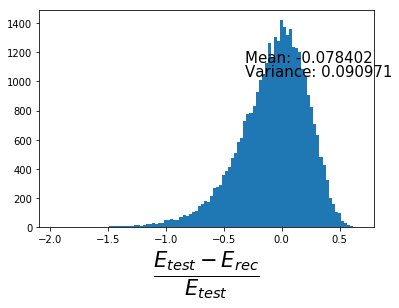

/Users/rubenlopez/anaconda/envs/cta-dev/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


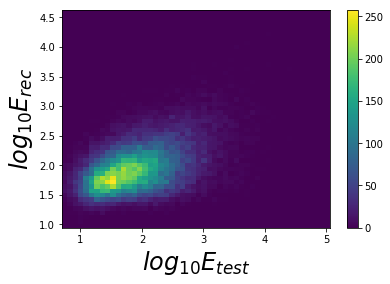

In [6]:
#First reconstruct energy                                                                                                                                                                                                                                                 

max_depth = 50
regr_rf_e = RandomForestRegressor(max_depth=max_depth, random_state=2)
regr_rf_e.fit(X_train, E_train)
erec = regr_rf_e.predict(X_test)


difE = ((E_test-erec)/E_test)
print(difE.mean(),difE.std())
plt.hist(difE,bins=100)
plt.xlabel('$\\frac{E_{test}-E_{rec}}{E_{test}}$',fontsize=30)
plt.figtext(0.6,0.7,'Mean: '+str(round(scipy.stats.describe(difE).mean,6)),fontsize=15)
plt.figtext(0.6,0.65,'Variance: '+str(round(scipy.stats.describe(difE).variance,6)),fontsize=15)
plt.show()

figE, ax = plt.subplots()
hE = ax.hist2d(E_test,erec,bins=50)
plt.colorbar(hE[3],ax=ax)
plt.xlabel('$log_{10}E_{test}$',fontsize=24)
plt.ylabel('$log_{10}E_{rec}$',fontsize=24)
figE.show()

-0.0457143538394 0.638557403403


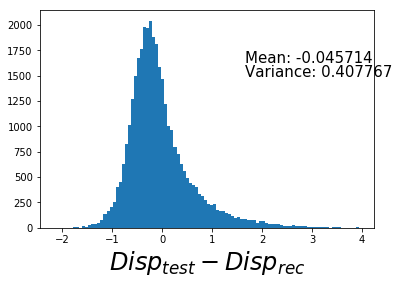

/Users/rubenlopez/anaconda/envs/cta-dev/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


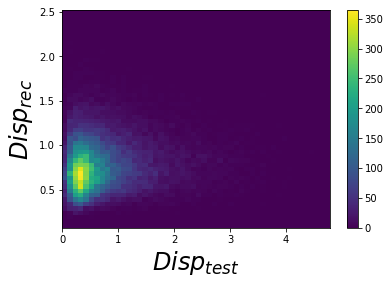

In [68]:
#Second, reconstruct DISP:                                                                                                                                                                                                                                                

max_depth = 50
regr_rf_d = RandomForestRegressor(max_depth=max_depth, random_state=2)
regr_rf_d.fit(X_train, D_train)
disprec = regr_rf_d.predict(X_test)

difD = ((D_test-disprec))
print(difD.mean(),difD.std())
plt.hist(difD,bins=100)
plt.xlabel('$Disp_{test} - Disp_{rec}$',fontsize=24)
plt.figtext(0.6,0.7,'Mean: '+str(round(scipy.stats.describe(difD).mean,6)),fontsize=15)
plt.figtext(0.6,0.65,'Variance: '+str(round(scipy.stats.describe(difD).variance,6)),fontsize=15)
plt.show()

figD, aax = plt.subplots()
hD = aax.hist2d(D_test,disprec,bins=50)
plt.colorbar(hD[3],ax=aax)
plt.xlabel('$Disp_{test}$',fontsize=24)
plt.ylabel('$Disp_{rec}$',fontsize=24)
figD.show()

/Users/rubenlopez/anaconda/envs/cta-dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.562186038455


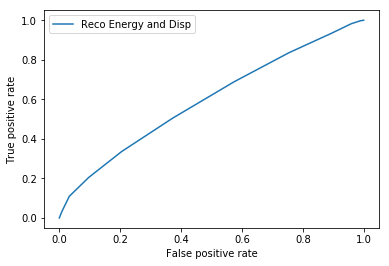

In [48]:
#Build the new set of training data:                                                                                                                                                                                                                                      
Energy_cut = 0.

nevents = X_test.shape[0]
nfeatures = X_test.shape[1]

newX = np.zeros((nevents,nfeatures+2))
newX[:,:-2] = X_test

newX = newX.T
newX[nfeatures] = erec
newX[nfeatures+1] = disprec

newX = newX.T

# Modified in case you apply an energy cuts
# only for test purposes!
nevents = X_test[erec > Energy_cut].shape[0]

newX_train, newX_test, newH_train, newH_test = train_test_split(newX[erec > Energy_cut], H_test[erec > Energy_cut],train_size=int(2*nevents/3),random_state=4)

clf = RandomForestClassifier(n_jobs=2,random_state=0)

clf.fit(newX_train,newH_train)

result = clf.predict(newX_test)

check = clf.predict_proba(newX_test)[0:,1]

accuracy = accuracy_score(newH_test, result)
print(accuracy)

fpr_rf, tpr_rf, _ = roc_curve(newH_test, check)

fig, ax = plt.subplots()
ax.plot(fpr_rf, tpr_rf, label='Reco Energy and Disp')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend(loc='best')
plt.show()


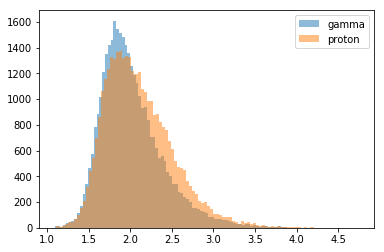

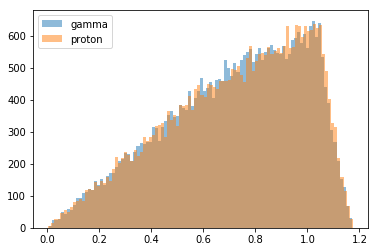

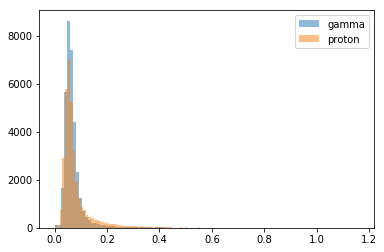

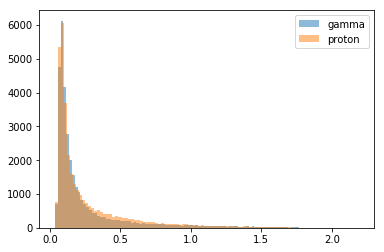

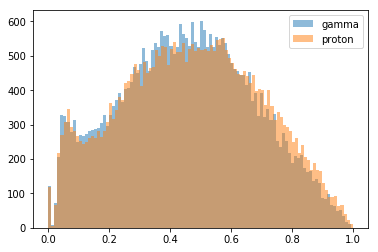

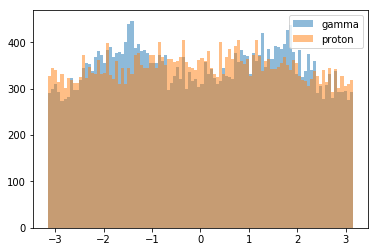

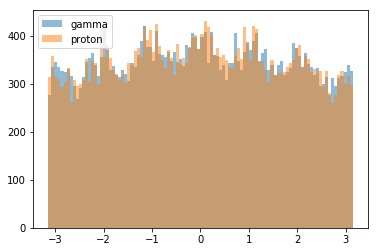

In [71]:
X_split=np.split(X,2)
for i in range(X.shape[1]):
    fig,ax = plt.subplots()
    if(i==0): # For the Size
        ax.hist(np.log10(X_split[0][:,i]),bins=100,color='C0',alpha=0.5,label='gamma')
        ax.hist(np.log10(X_split[1][:,i]),bins=100,color='C1',alpha=0.5,label='proton')   
    else:
        ax.hist(X_split[0][:,i],bins=100,color='C0',alpha=0.5,label='gamma')
        ax.hist(X_split[1][:,i],bins=100,color='C1',alpha=0.5,label='proton')
    ax.legend()